In [28]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Digit preprocessing

In [29]:
from skimage.measure import label, regionprops
from skimage.transform import resize
from skimage import util
from skimage.segmentation import clear_border

import numpy as np

def chars74_preprocessing(digit):  

    w, h = digit.shape[:2]
    # remove artifacts connected to image border
    cleared = digit #clear_border(digit)   
   
    label_image = label(cleared)
   
    def distance(tuple_1, tuple_2):
        return np.abs(tuple_1[0] - tuple_2[0]) + np.abs(tuple_1[1] - tuple_2[1])

    
    def is_digit(region, center, w, h):        
        return (region.eccentricity < 0.99 and # might be not usefull thanks to last parameter
                distance(region.centroid, center) < w / 2.5 and                
                region.bbox_area < (w*h) / 2 and
                region.bbox_area > (w*h) / 30 and
                region.bbox[2] - region.bbox[0] < w)
    

    center = (w / 2, h / 2)    
    props = [r for r in regionprops(label_image) if is_digit(r, center, w, h)]
    region = None
    if len(props) == 0:
        return np.zeros((64, 64)), False # TODO: return black image (+ indicateur ?)
    if len(props) == 1:
        region = props[0]
    else:
        print('multiple region !')
        region = sorted(props, key=lambda r: distance(r.centroid, center))[0]
        #raise Exception('houlala')

    minr, minc, maxr, maxc = region.bbox
    cropped = digit[minr:maxr, minc:maxc]
    w_crop, h_crop = cropped.shape[:2]

    before = abs(w_crop - h_crop) // 2
    after = abs(w_crop - h_crop) - before

    PIX_FRAME = 5
    
    if w_crop > h_crop:
        pad_width = ((0, 0), (before, after))
    else:
        pad_width = ((before + PIX_FRAME, after + PIX_FRAME), (0, 0))

    
    padded = util.pad(cropped, pad_width, mode='constant')
    padded = resize(padded, (64, 64))    

    # util.invert(padded)
    return util.invert(padded), True

# Pipeline

In [75]:
from sudoku_solver.data import SudokuGrid
from sudoku_solver.common import plot_digits

class SudokuPipeline:
    def __init__(self, extractor, classifier, solver):
        self.extractor = extractor
        self.classifier = classifier
        self.solver = solver       
        
    def launch(self, input_img):
        raw_digits = self.extractor.extract_digits(input_img)
        proc_digits = np.empty((9,9), dtype=object) # Empty array
        digits = np.empty((9,9), dtype=object)        
        
        for i in range(len(raw_digits)):
            for j in range(len(raw_digits[i])):                
                proc_digit, is_digit = self.classifier.preprocess(raw_digits[i][j])
                proc_digits[i][j] = proc_digit
                label = 0       
                if is_digit:            
                    label = self.classifier.predict(proc_digit)                    
                digits[i][j] = label
                
        plot_digits(raw_digits)  
        plot_digits(proc_digits)
        print(digits)
        return SudokuGrid(digits)

In [76]:
from sudoku_solver.extract import ScikitImageExtractor
from sudoku_solver.classify import ScikitLearnClassifier

# 1. Extractor
extractor = ScikitImageExtractor(
    show_steps=False
    # add an option for output ? (binary or not)
)

# 2. Classifier
classifier = ScikitLearnClassifier(
    model_path='models/chars74k/forest_clf.joblib',
    preproc_fun=chars74_preprocessing
)

pipeline = SudokuPipeline(extractor, classifier, None)

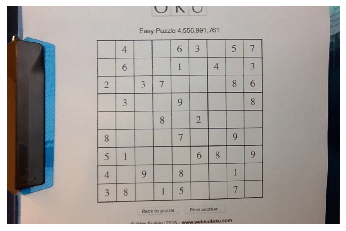

In [83]:
from sudoku_solver.common import load_img, plot_img

img_path = 'datasets/bernard/2.jpg'
input_img = load_img(img_path)
plot_img(input_img)

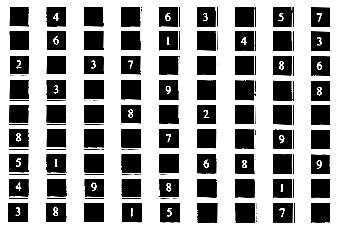

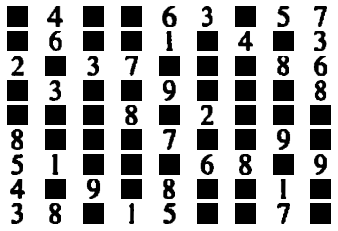

[[0 4 0 0 6 3 0 5 7]
 [0 6 0 0 1 0 4 0 3]
 [2 0 3 3 0 0 0 8 6]
 [0 3 0 0 9 0 0 0 8]
 [0 0 0 8 0 2 0 0 0]
 [8 0 0 0 7 0 0 9 0]
 [5 1 0 0 0 6 8 0 9]
 [4 0 9 0 8 0 0 1 0]
 [3 8 0 1 5 0 0 7 0]]


In [84]:
sudoku_grid = pipeline.launch(input_img)

In [85]:
print(sudoku_grid)

040|063|057
060|010|403
203|300|086
-----------
030|090|008
000|802|000
800|070|090
-----------
510|006|809
409|080|010
380|150|070



# Pipeline

## Load database

In [ ]:
# TODO

## Launch pipeline

In [ ]:
if __name__ == '__main__':
    #img = load_img('datasets/mathworks/segmentation_data/raw_data/images/0010_05.jpg')
    for i in range(14, 15):
        img_path = 'datasets/bernard/{}.jpg'.format(i)
        print(img_path)
        img = load_img(img_path)
        launch_pipeline(img)